In [127]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import math

from keras.models import Sequential
from keras.layers import LSTM, Dense

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [128]:
def quartersToHours(data):
    data['date_forecast'] = pd.to_datetime(data['date_forecast'], format='%Y-%m.%d %H:%M:%S')
    data["year"] = data['date_forecast'].dt.year
    data["month"] = data['date_forecast'].dt.month
    data["day"] = data['date_forecast'].dt.day
    data["hour"] = data['date_forecast'].dt.hour


    group = data.groupby([data["year"], data["month"], data["day"], data["hour"]])  
    result = group.mean()
    result = result.reset_index()
    
    return_df = result.drop(['year','month', 'day', 'hour'], axis=1)
    
    return return_df

In [129]:
def join_data_and_labels(train, val, labels):
    
    #Remove hour and minute values
    val = val.assign(date_forecast=val.date_forecast.dt.round('H'))
    train = train.assign(date_forecast=train.date_forecast.dt.round('H'))
    
    #rename columns names to match
    
    train = train.rename(columns={'date_forecast': 'date'})
    val = val.rename(columns={'date_forecast': 'date'})
    labels = labels.rename(columns={'time': 'date'})
    
    joined_train = pd.merge(train, labels, how="inner", on="date")
    joined_val = pd.merge(val, labels, how="inner", on="date")

    
    return joined_train, joined_val

In [130]:
def remove_unused_columns(df):
    df = df.drop(['wind_speed_10m:ms', 'elevation:m', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
                 'wind_speed_w_1000hPa:ms'], axis=1)
    return df

In [131]:
def drop_constanst_columns(train, val, test):
    constanst_columns = []
    # Remove constants
    for key, value in train.std().items():
        if value == 0.0:
            constanst_columns.append(key)

    for key in constanst_columns:
        if val.std()[key] != 0.0 or test.std()[key] != 0.0:
            constanst_columns.remove(key)

    for key in constanst_columns:
        train = train.drop([key], axis=1)
        val = val.drop([key], axis=1)
        test = test.drop([key], axis=1)

In [132]:
def convert_date_to_sin_and_cos(df):
    day = 24*60*60 #seconds in a day
    year = (365.2425)*day #seconds in a year
    month = year / 12.0

    date_time = pd.to_datetime(df.pop('date'), format='%Y-%m.%d %H:%M:%S')
    timestamp_s = date_time.map(pd.Timestamp.timestamp)
    print(timestamp_s)

    #df['Month sin'] = np.sin(timestamp_s * (2 * np.pi / month))
    #df['Month cos'] = np.cos(timestamp_s * (2 * np.pi / month))
    
    df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    
    df['Hour sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Hour cos'] = np.cos(timestamp_s * (2 * np.pi / day))

In [133]:
def round_is_day(df):
    df["is_day:idx"] = [round(df["is_day:idx"][i]) for i in range(len(df))]
    df["is_in_shadow:idx"] = [round(df["is_in_shadow:idx"][i]) for i in range(len(df))]
    

In [134]:
def normalize_except_columns(df):
    not_to_be_norm = ["is_day:idx", "Year sin", "Year cos", 'is_in_shadow:idx', 'Hour sin', 'Hour cos']
    cols = df.columns.tolist()
    cols_to_norm = [i for i in cols if i not in not_to_be_norm]
    
    df[cols_to_norm] = df[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))


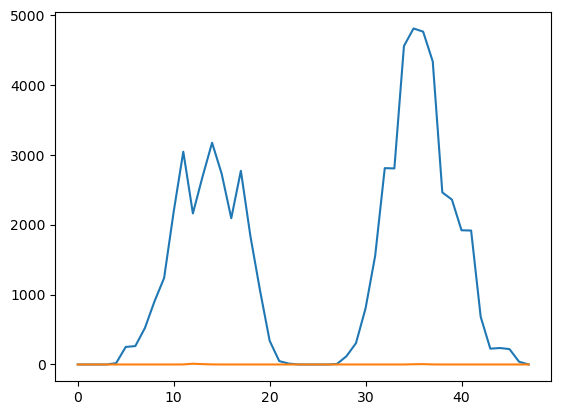

In [135]:
train_a = pd.read_parquet('dataset/A/train_targets.parquet')
train_b = pd.read_parquet('dataset/B/train_targets.parquet')
train_c = pd.read_parquet('dataset/C/train_targets.parquet')

plt.plot(train_a["pv_measurement"][0:24 * 2])
plt.plot(train_b["pv_measurement"][0:24 * 2])
plt.plot(train_c["pv_measurement"][0:24 * 2])

In [136]:
a_max = train_a["pv_measurement"].max()
b_max = train_b["pv_measurement"].max()
c_max = train_c["pv_measurement"].max()

In [137]:
#Load data, sample to hours and drop columns which are not needed
X_train_observed_a = quartersToHours(pd.read_parquet('dataset/A/X_train_observed.parquet')) #Train_x
X_train_observed_b = quartersToHours(pd.read_parquet('dataset/B/X_train_observed.parquet'))
X_train_observed_c = quartersToHours(pd.read_parquet('dataset/C/X_train_observed.parquet'))

X_train_estimated_a = quartersToHours(pd.read_parquet('dataset/A/X_train_estimated.parquet')) # Val_x
X_train_estimated_a = X_train_estimated_a.drop(["date_calc"], axis=1)

X_train_estimated_b = quartersToHours(pd.read_parquet('dataset/B/X_train_estimated.parquet'))
X_train_estimated_b = X_train_estimated_b.drop(["date_calc"], axis=1)

X_train_estimated_c = quartersToHours(pd.read_parquet('dataset/C/X_train_estimated.parquet'))
X_train_estimated_c = X_train_estimated_c.drop(["date_calc"], axis=1)

X_test_estimated_a = quartersToHours(pd.read_parquet('dataset/A/X_test_estimated.parquet'))
X_test_estimated_a = X_test_estimated_a.drop(["date_calc"], axis=1)
test_a = X_test_estimated_a.rename(columns={'date_forecast': 'date'})

X_test_estimated_b = quartersToHours(pd.read_parquet('dataset/B/X_test_estimated.parquet'))
X_test_estimated_b = X_test_estimated_b.drop(["date_calc"], axis=1)
test_b = X_test_estimated_b.rename(columns={'date_forecast': 'date'})

X_test_estimated_c = quartersToHours(pd.read_parquet('dataset/C/X_test_estimated.parquet'))
X_test_estimated_c = X_test_estimated_c.drop(["date_calc"], axis=1)
test_c = X_test_estimated_c.rename(columns={'date_forecast': 'date'})

In [138]:
# Join data and labels into one df
train_data_a, val_data_a = join_data_and_labels(X_train_observed_a, X_train_estimated_a, train_a)
train_data_b, val_data_b = join_data_and_labels(X_train_observed_b, X_train_estimated_b, train_b)
train_data_c, val_data_c = join_data_and_labels(X_train_observed_c, X_train_estimated_c, train_c)

In [139]:
# Remove columns which are not needed
train_data_a = remove_unused_columns(train_data_a)
val_data_a = remove_unused_columns(val_data_a)
test_a = remove_unused_columns(test_a)

train_data_b = remove_unused_columns(train_data_b)
val_data_b = remove_unused_columns(val_data_b)
test_b = remove_unused_columns(test_b)

train_data_c = remove_unused_columns(train_data_c)
val_data_c = remove_unused_columns(val_data_c)
test_c = remove_unused_columns(test_c)

In [140]:
# Drop columns which are constant
drop_constanst_columns(train_data_a, val_data_a, test_a)
drop_constanst_columns(train_data_b, val_data_b, test_b)
drop_constanst_columns(train_data_c, val_data_c, test_c)

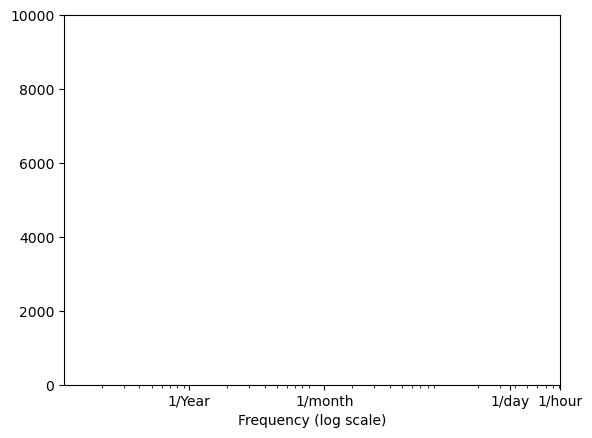

In [141]:
fft = tf.signal.rfft(train_data_b['pv_measurement'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(train_data_b['pv_measurement'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 10000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524, 12, 365.2524 * 2.5,], labels=['1/Year', '1/day', '1/month', '1/hour'])
_ = plt.xlabel('Frequency (log scale)')

In [142]:
# Convert date into sin and cos components
convert_date_to_sin_and_cos(train_data_a)
convert_date_to_sin_and_cos(val_data_a)
convert_date_to_sin_and_cos(test_a)

convert_date_to_sin_and_cos(train_data_b)
convert_date_to_sin_and_cos(val_data_b)
convert_date_to_sin_and_cos(test_b)

convert_date_to_sin_and_cos(train_data_c)
convert_date_to_sin_and_cos(val_data_c)
convert_date_to_sin_and_cos(test_c)

0        1.559513e+09
1        1.559516e+09
2        1.559520e+09
3        1.559524e+09
4        1.559527e+09
             ...     
29662    1.666296e+09
29663    1.666300e+09
29664    1.666303e+09
29665    1.666307e+09
29666    1.666310e+09
Name: date, Length: 29667, dtype: float64
0       1.666994e+09
1       1.666998e+09
2       1.667002e+09
3       1.667005e+09
4       1.667009e+09
            ...     
4389    1.682881e+09
4390    1.682885e+09
4391    1.682888e+09
4392    1.682892e+09
4393    1.682896e+09
Name: date, Length: 4394, dtype: float64
0      1.682901e+09
1      1.682904e+09
2      1.682908e+09
3      1.682911e+09
4      1.682915e+09
           ...     
715    1.688412e+09
716    1.688416e+09
717    1.688419e+09
718    1.688423e+09
719    1.688427e+09
Name: date, Length: 720, dtype: float64
0        1.546301e+09
1        1.546304e+09
2        1.546308e+09
3        1.546312e+09
4        1.546315e+09
             ...     
29217    1.651518e+09
29218    1.651522e+09
29219   

In [143]:
# Isday should be a binary value
round_is_day(train_data_a)
round_is_day(val_data_a)
round_is_day(test_a)

round_is_day(train_data_b)
round_is_day(val_data_b)
round_is_day(test_b)

round_is_day(train_data_c)
round_is_day(val_data_c)
round_is_day(test_c)

In [144]:
normalize_except_columns(train_data_a)
normalize_except_columns(val_data_a)
normalize_except_columns(test_a)

normalize_except_columns(train_data_b)
normalize_except_columns(val_data_b)
normalize_except_columns(test_b)

normalize_except_columns(train_data_c)
normalize_except_columns(val_data_c)
normalize_except_columns(test_c)

In [145]:
# Fill 0 for NaNs
train_data_a = train_data_a.fillna(0)
val_data_a = val_data_a.fillna(0)
test_a = test_a.fillna(0)

train_data_b = train_data_b.fillna(0)
val_data_b = val_data_b.fillna(0)
test_b = test_b.fillna(0)

train_data_c = train_data_c.fillna(0)
val_data_c = val_data_c.fillna(0)
test_c = test_c.fillna(0)

In [164]:
train_data_b.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
absolute_humidity_2m:gm3,29222.0,0.325890,0.163805,0.0,0.205706,2.912913e-01,0.435435,1.0
air_density_2m:kgm3,29222.0,0.375025,0.128752,0.0,0.286497,3.731752e-01,0.458029,1.0
ceiling_height_agl:m,29222.0,0.183221,0.196819,0.0,0.052938,1.185570e-01,0.239017,1.0
clear_sky_energy_1h:J,29222.0,0.181470,0.280465,0.0,0.000000,6.132575e-03,0.291670,1.0
clear_sky_rad:W,29222.0,0.180398,0.279497,0.0,0.000000,3.712130e-03,0.290774,1.0
cloud_base_agl:m,29222.0,0.138316,0.148053,0.0,0.045522,9.617243e-02,0.169807,1.0
dew_or_rime:idx,29222.0,0.504243,0.055467,0.0,0.500000,5.000000e-01,0.500000,1.0
dew_point_2m:K,29222.0,0.575216,0.159174,0.0,0.471210,5.687425e-01,0.698590,1.0
diffuse_rad:W,29222.0,0.123117,0.184439,0.0,0.000000,5.116244e-03,0.208148,1.0
diffuse_rad_1h:J,29222.0,0.123656,0.183102,0.0,0.000000,1.252838e-02,0.207540,1.0


In [147]:
MAX_EPOCHS = 20

def compile_and_fit(model, train_x, train_y, val_x, val_y, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(x= train_x, y=train_y, epochs=MAX_EPOCHS,
                      validation_data=(val_x, val_y),
                       callbacks=[early_stopping])
    return history

In [148]:
def split_and_batch(df):
    df_labels = df.pop("pv_measurement")
    
    BATCH_SIZE=30

    df_arr = np.array(df, dtype=np.float32)
    df_label_arr = np.array(df_labels, dtype=np.float32)

    # Calculate the number of batches needed
    num_batches = df_arr.shape[0] // BATCH_SIZE

    # Reshape the 2D array into a 3D array with shape (num_batches, BATCH_SIZE, 48)
    if df_arr.shape[0] % BATCH_SIZE == 0:
        # If the data size is a multiple of BATCH_SIZE
        data_3d = df_arr.reshape(num_batches, BATCH_SIZE, -1)
        label_3d = df_label_arr.reshape(num_batches, BATCH_SIZE, -1)

    else:
        # If there's some remaining data that doesn't fit perfectly into batches
        remaining_rows = df_arr.shape[0] % BATCH_SIZE
        data_3d = df_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)
        label_3d = df_label_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)

    return data_3d, label_3d

In [149]:
def batch(df):
    BATCH_SIZE=30

    df_arr = np.array(df, dtype=np.float32)

    # Calculate the number of batches needed
    num_batches = df_arr.shape[0] // BATCH_SIZE

    # Reshape the 2D array into a 3D array with shape (num_batches, BATCH_SIZE, 48)
    if df_arr.shape[0] % BATCH_SIZE == 0:
        # If the data size is a multiple of BATCH_SIZE
        data_3d = df_arr.reshape(num_batches, BATCH_SIZE, -1)

    else:
        # If there's some remaining data that doesn't fit perfectly into batches
        remaining_rows = df_arr.shape[0] % BATCH_SIZE
        data_3d = df_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)

    return data_3d
    

In [150]:
train_a_x, train_a_y = split_and_batch(train_data_a)
val_a_x, val_a_y = split_and_batch(val_data_a)

train_b_x, train_b_y = split_and_batch(train_data_b)
val_b_x, val_b_y = split_and_batch(val_data_b)

train_c_x, train_c_y = split_and_batch(train_data_c)
val_c_x, val_c_y = split_and_batch(val_data_c)

test_a = batch(test_a)
test_b = batch(test_b)
test_c = batch(test_c)

In [205]:
lstm_model_a = tf.keras.models.Sequential([   
    tf.keras.layers.Dense(units=30,
                    kernel_initializer='random_uniform',
                    bias_initializer='zeros'),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    #tf.keras.layers.LSTM(64, return_sequences=True),
    #tf.keras.layers.Dense(units=48),
    #tf.keras.layers.Dense(units=32),

    tf.keras.layers.Dense(units=1, activation="relu")
])

lstm_model_b = tf.keras.models.clone_model(lstm_model_a)
lstm_model_c = tf.keras.models.clone_model(lstm_model_b)

In [206]:
history_a = compile_and_fit(lstm_model_a,train_a_x, train_a_y, val_a_x, val_a_y)
print(f'measure a: {lstm_model_a.evaluate(val_a_x, val_a_y)}')

#[0.006232030689716339, 0.03161332383751869]
#[0.005147780757397413, 0.028607070446014404] -> year and day
#[0.004300971981137991, 0.02555842511355877]

Epoch 1/20
31/31 [==============================] - 10s 102ms/step - loss: 0.0283 - mean_absolute_error: 0.1022 - val_loss: 0.0095 - val_mean_absolute_error: 0.0435
Epoch 2/20
31/31 [==============================] - 1s 40ms/step - loss: 0.0131 - mean_absolute_error: 0.0578 - val_loss: 0.0080 - val_mean_absolute_error: 0.0353
Epoch 3/20
31/31 [==============================] - 1s 38ms/step - loss: 0.0111 - mean_absolute_error: 0.0530 - val_loss: 0.0061 - val_mean_absolute_error: 0.0322
Epoch 4/20
31/31 [==============================] - 1s 38ms/step - loss: 0.0096 - mean_absolute_error: 0.0487 - val_loss: 0.0057 - val_mean_absolute_error: 0.0303
Epoch 5/20
31/31 [==============================] - 1s 38ms/step - loss: 0.0089 - mean_absolute_error: 0.0465 - val_loss: 0.0057 - val_mean_absolute_error: 0.0299
Epoch 6/20
31/31 [==============================] - 1s 39ms/step - loss: 0.0084 - mean_absolute_error: 0.0456 - val_loss: 0.0051 - val_mean_absolute_error: 0.0311
Epoch 7/20
31/31 [==

In [207]:
history_b = compile_and_fit(lstm_model_b,train_b_x, train_b_y, val_b_x, val_b_y)
print(f'measure b: {lstm_model_b.evaluate(val_b_x, val_b_y)}')

#[0.007145202253013849, 0.03178989142179489]
#[0.008217844180762768, 0.03327266126871109]
#[0.0067342291586101055, 0.030065299943089485]

Epoch 1/20
31/31 [==============================] - 10s 83ms/step - loss: 0.0179 - mean_absolute_error: 0.0754 - val_loss: 0.0086 - val_mean_absolute_error: 0.0332
Epoch 2/20
31/31 [==============================] - 1s 38ms/step - loss: 0.0094 - mean_absolute_error: 0.0478 - val_loss: 0.0082 - val_mean_absolute_error: 0.0324
Epoch 3/20
31/31 [==============================] - 1s 38ms/step - loss: 0.0087 - mean_absolute_error: 0.0458 - val_loss: 0.0072 - val_mean_absolute_error: 0.0303
Epoch 4/20
31/31 [==============================] - 1s 39ms/step - loss: 0.0082 - mean_absolute_error: 0.0445 - val_loss: 0.0064 - val_mean_absolute_error: 0.0290
Epoch 5/20
31/31 [==============================] - 1s 38ms/step - loss: 0.0078 - mean_absolute_error: 0.0436 - val_loss: 0.0071 - val_mean_absolute_error: 0.0302
Epoch 6/20
31/31 [==============================] - 1s 38ms/step - loss: 0.0076 - mean_absolute_error: 0.0428 - val_loss: 0.0058 - val_mean_absolute_error: 0.0281
Epoch 7/20
31/31 [===

In [208]:
history_c = compile_and_fit(lstm_model_c,train_c_x, train_c_y, val_c_x, val_c_y)
print(f'measure c: {lstm_model_c.evaluate(val_c_x, val_c_y)}')

#[0.004318469204008579, 0.02518327347934246]
#[0.004314047750085592, 0.025382312014698982]
#[0.003403852926567197, 0.02470281533896923]

Epoch 1/20
31/31 [==============================] - 9s 82ms/step - loss: 0.0169 - mean_absolute_error: 0.0661 - val_loss: 0.0053 - val_mean_absolute_error: 0.0272
Epoch 2/20
31/31 [==============================] - 1s 38ms/step - loss: 0.0126 - mean_absolute_error: 0.0516 - val_loss: 0.0037 - val_mean_absolute_error: 0.0233
Epoch 3/20
31/31 [==============================] - 1s 38ms/step - loss: 0.0118 - mean_absolute_error: 0.0496 - val_loss: 0.0034 - val_mean_absolute_error: 0.0254
Epoch 4/20
31/31 [==============================] - 1s 38ms/step - loss: 0.0119 - mean_absolute_error: 0.0496 - val_loss: 0.0037 - val_mean_absolute_error: 0.0244
Epoch 5/20
31/31 [==============================] - 1s 38ms/step - loss: 0.0112 - mean_absolute_error: 0.0480 - val_loss: 0.0031 - val_mean_absolute_error: 0.0234
Epoch 6/20
31/31 [==============================] - 1s 40ms/step - loss: 0.0114 - mean_absolute_error: 0.0481 - val_loss: 0.0032 - val_mean_absolute_error: 0.0229
Epoch 7/20
4/4 [======

In [210]:
#lstm_model_a.get_weight_paths()

In [211]:
pred_a = lstm_model_a.predict(test_a)
pred_b = lstm_model_b.predict(test_b)
pred_c = lstm_model_c.predict(test_c)

pred_a_val = lstm_model_a.predict(val_a_x)
pred_b_val = lstm_model_b.predict(val_b_x)
pred_c_val = lstm_model_c.predict(val_c_x)

4/4 [==============================] - 0s 12ms/step


In [212]:
pred_a = pred_a.flatten() * a_max
pred_b = pred_b.flatten() * b_max
pred_c = pred_c.flatten() * c_max

pred_a_val = pred_a_val.flatten() * a_max
pred_b_val = pred_b_val.flatten() * b_max
pred_c_val = pred_c_val.flatten() * c_max

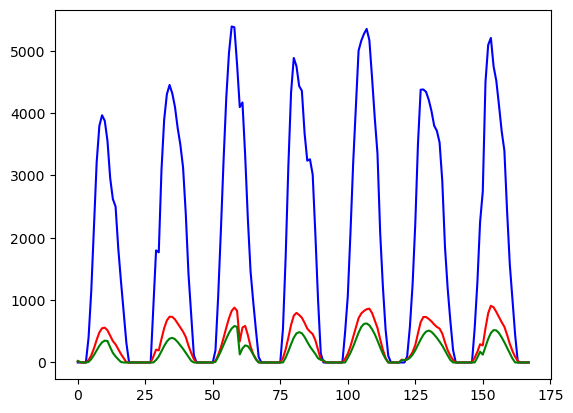

In [213]:
plt.plot(pred_a[0:24*7], color="blue")
plt.plot(pred_b[0:24*7], color="red")
plt.plot(pred_c[0:24*7], color="green")

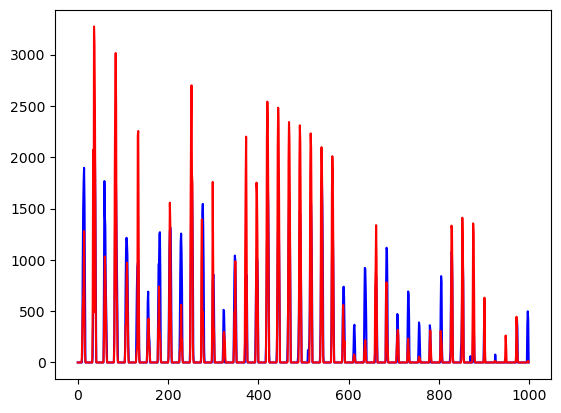

In [214]:
plt.plot(pred_a_val[:1000], color="blue")
plt.plot(val_a_y.flatten()[:1000] * a_max, color="red")

In [215]:
test = pd.read_csv('test.csv')

test

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0,A
1,1,2023-05-01 01:00:00,0,A
2,2,2023-05-01 02:00:00,0,A
3,3,2023-05-01 03:00:00,0,A
4,4,2023-05-01 04:00:00,0,A
...,...,...,...,...
2155,2155,2023-07-03 19:00:00,0,C
2156,2156,2023-07-03 20:00:00,0,C
2157,2157,2023-07-03 21:00:00,0,C
2158,2158,2023-07-03 22:00:00,0,C


In [216]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,id,prediction
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2155,2155,0
2156,2156,0
2157,2157,0
2158,2158,0


In [217]:
submit = np.concatenate((np.concatenate((pred_a, pred_b)),pred_c))

In [218]:
# Example, let the predictions be random values
test['prediction'] = submit
sample_submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv('4th.csv', index=False)